In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
%matplotlib inline
import os

In [ ]:
path = "/content/drive/MyDrive/cs3244-pg26/data_processed/resale_flat_prices"
df = pd.read_csv(os.path.join(path, "engineered_data.csv"))

In [4]:
df = pd.read_csv("../../data_processed/resale_flat_prices/engineered_data.csv")
display(df.head(5))

,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN
3,4,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
4,5,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,11.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN


In [5]:
from sklearn.impute import SimpleImputer

df["is_imputted_sora"] = np.where(df["avg_sora"].isnull(), 1, 0)

imp = SimpleImputer()
df["avg_sora"] = imp.fit_transform(df["avg_sora"].to_numpy().reshape(-1, 1))

df.drop(columns=["id", "sale_date", "address", "latitude_rad", "longitude_rad", "latitude", "longitude", "psm"], inplace=True)

df = pd.get_dummies(df, columns=["flat_type", "flat_model", "town"], dummy_na = True, dtype=np.uint8)
df.drop(columns=["town_nan", "flat_type_nan", "flat_model_nan"], inplace=True)

print(df.shape, '\n', df.columns)
display(df.head(3))

(865827, 58) 
 Index(['floor', 'age', 'relative_tenure', 'floor_area', 'nearest_atm',
       'nearest_libraries', 'nearest_hawkers', 'nearest_stores',
       'nearest_post_offices', 'nearest_bus_stops', 'nearest_pharmacies',
       'nearest_primary_schools', 'nearest_parks', 'nearest_trains',
       'sale_month', 'cpi', 'cpi_psm', 'avg_sora', 'is_imputted_sora',
       'flat_type_3_ROOM', 'flat_type_4_ROOM', 'flat_type_5_ROOM',
       'flat_type_EXECUTIVE', 'flat_type_OTHER', 'flat_model_APARTMENT',
       'flat_model_IMPROVED', 'flat_model_MAISONETTE', 'flat_model_MODEL_A',
       'flat_model_MODEL_A2', 'flat_model_NEW_GENERATION', 'flat_model_OTHER',
       'flat_model_PREMIUM_APARTMENT', 'flat_model_SIMPLIFIED',
       'flat_model_STANDARD', 'town_ANG_MO_KIO', 'town_BEDOK', 'town_BISHAN',
       'town_BUKIT_BATOK', 'town_BUKIT_MERAH', 'town_BUKIT_PANJANG',
       'town_CHOA_CHU_KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG_EAST', 'town_JURONG_WEST', 'to

,floor,age,relative_tenure,floor_area,nearest_atm,nearest_libraries,nearest_hawkers,nearest_stores,nearest_post_offices,nearest_bus_stops,...,town_PASIR_RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA_PAYOH,town_WOODLANDS,town_YISHUN
0,5.0,16,0.899953,70.0,0.521140,0.751719,0.576328,0.521140,0.798752,0.195397,...,0,0,0,0,0,0,0,0,0,0
1,5.0,15,0.902280,120.0,0.391706,0.930882,0.290215,0.368291,3.042559,0.090376,...,0,0,0,0,0,0,0,0,0,0
2,5.0,15,0.902280,63.0,0.165177,1.399324,0.165177,0.047929,1.148847,0.446105,...,0,0,0,0,0,0,0,0,0,0


In [6]:
lookback_years = 4
latest_month = df.sale_month.max()
test_months = list(range(latest_month - lookback_years * 12, latest_month + 1))
train_months = list(range(1, latest_month - lookback_years * 12))

df_train, df_test = deepcopy(df[df.sale_month.isin(train_months)]), deepcopy(df[df.sale_month.isin(test_months)])

X_train, X_test, y_train, y_test = df_train.drop('cpi_psm', axis=1), df_test.drop('cpi_psm', axis=1), df_train.cpi_psm, df_test.cpi_psm

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(767022, 57) (767022,)
(98805, 57) (98805,)


In [7]:
def produce_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rtwo = r2_score(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
  return mse, mse**(0.5), mae, rtwo, mape, mdape

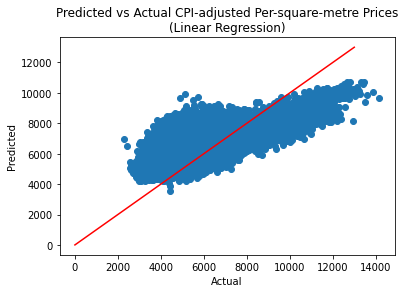

In [ ]:
#Linear regression
model = LinearRegression()
model.fit(X_train, y_train)

#Linear regression score based on prediction
y_pred = model.predict(X_test)
model.score(X_test, y_test)
plt.scatter(y_test,y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(Linear Regression)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(np.linspace(0,13000,100),np.linspace(0,13000,100), "-r")
plt.show()

In [ ]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 1491429.943003844
RMSE: 1221.241148587716
MAE: 1058.5290378911714
R2: 0.2522715011327191
MAPE: 0.21898762901191487
MdAPE: 0.2042421168737615


In [8]:
# Using polynomial regression
i = 2 #Degree of polynomial
poly = PolynomialFeatures(degree = i)
poly_X = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly.fit(poly_X, y_train)
model = LinearRegression()
model = model.fit(poly_X, y_train)

y_pred = model.predict(poly_X_test)
plt.scatter(y_test,y_pred)
plt.title("Polynomial degression of degree " + str(i))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(np.linspace(0,13000,100),np.linspace(0,13000,100), "-r")
plt.show()

In [ ]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

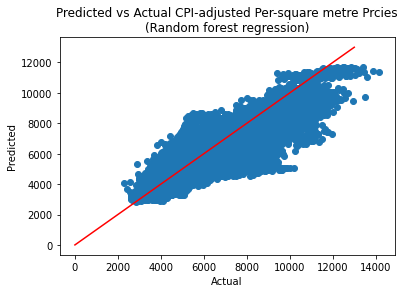

In [ ]:
#Trying out random forest regressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 50)
model = model.fit(X_train, y_train)

#Predict the testing data
y_pred = model.predict(X_test)
plt.scatter(y_test,y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square metre Prcies\n(Random Forest Regression)")
plt.plot(np.linspace(0,13000,100),np.linspace(0,13000,100), "-r")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [ ]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 437635.175190885
RMSE: 661.5400027140347
MAE: 474.717994549444
R2: 0.780591576471952
MAPE: 0.08558147762790735
MdAPE: 0.06968405815790558


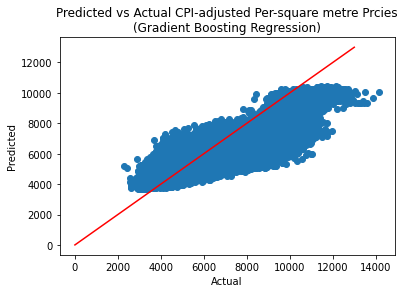

In [ ]:
#Gradient boosting regression
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators = 100)
model = model.fit(X_train, y_train)

# generating predictions for the gradient boosting regressor
y_pred = model.predict(X_test)
plt.scatter(y_test,y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square metre Prcies\n(Gradient Boosting Regression)")
plt.plot(np.linspace(0,13000,100),np.linspace(0,13000,100), "-r")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [ ]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 768207.637402613
RMSE: 876.4745503450816
MAE: 642.4210206645373
R2: 0.6148590510550347
MAPE: 0.11563772720892623
MdAPE: 0.09648523495342698


In [ ]:
from google.colab import runtime
runtime.unassign()